In [1]:
# Step 1: Data Preperation

# The most common question I've gotten from students in the class so far is
# "how do I start?" It's a big project and can be daunting, so here are a couple
# of tips on how to get started!

# First, I like to bring in data I have, in this case the training set, and
# split it up right away into three subsets: train/test/holdout. I think it
# would be reasonable to do this by the event.id, but there are other ways too

import pandas as pd
import numpy as np
import cloudpickle
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
events=df['event.id'].unique()

df['x_result.duration.chip']=pd.to_timedelta(df['result.duration.chip']).astype(int)

train_set=events[0:100]
test_set=events[100:200]
holdout_set=events[200:300]

train=df.query("`event.id` in @train_set")
test=df.query("`event.id` in @test_set")
holdout=df.query("`event.id` in @holdout_set")

# You notice how I just hard coded some slices in and made the sets the same
# size. You don't have to do this, and in the end, you want to submit your models
# to the autograder using *all* of the data in this dataset. But this is real
# world data so there will be weird format errors, and having a clear holdout
# set will give you a chance to "fail fast" and see those errors crop up without
# having to submit to the autograder
    
# Speaking about the holdout dataset, it will not have a bunch of data in it, like
# race times. That would of course leak the results, and wouldn't be available in
# practice. The addendum to the assignment has this description, and I just copy
# and past it here and create the same thing. This ensures when I am playing with
# my models and then want to evaluate them I won't make a mistake and use a
# column incorrectly.

holdout=holdout.drop(
    columns=['time.end',
             'body.results_certificate',
             'event.results_posted',
             'event.results_posted',
             'event.results_certificate',
             'event.photos_available',
             'event.photos_faces',
             'event.photos_social_sharing',
             'event.results_searchable',
             'corral.id',
             'corral.name',
             'corral.wave',
             'corral.time.close',
             'corral.time.start',
             'result.duration.chip',
             'result.duration.pace',
             'result.rankings',
             'result.splits',
             'result.videos',
             'result.finished',
             'result.disqualified',
             'result.duration'])

# Also, I will garuntee in the holdout set there is data. At least 6 rows per race
holdout=df.groupby(["event.id","clean_categories.name"]).filter(lambda z: len(z)>5)

# So now when I test models agains this holdout data I can be fairly certain
# that it is indicative of future data. No garuntees, I still need to build robust
# models, but this is helpful!

In [2]:
# Step 2: Use the autograder!

# I gave you the autograder code, so a next great step is just to copy and paste
# that in your notebook and get used to how it works.
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

# This code simulates the autograder. It is not the full autograder implementation
# but shares an API with the autograder. It expects that your fitted pipeline is
# submitted with the name pipeline.cloudpickle as demonstrated above. This object
# must implement the predict() function. This is done automatically by the sklearn
# Pipeline object if the last element of your pipeline is a classifier which has
# a predict() function. If you are not submitting a Pipeline, and want to do something
# different, you *must* have a predict() function of the same method signature, e.g.:
#
#   predict(self, X, **predict_params)->np.ndarray

# Load holdout data, in this case I'll simulate it by loading the training data
#df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# And evaluate on all 5k races that we didn't consider for training
#holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")
holdout_data=holdout

# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    # Load student pipeline
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    # Ensure there is data to actually predict on
    if len(data)==0:
        return np.nan

    # Predict on unseen data
    from IPython.utils import io
    with io.capture_output() as captured:
        predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)

    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

def autograde(data_held_out):
    # Run prediction on each group
    results=data_held_out.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

    # Display the results, uncomment this for your own display
    results.reset_index()['score'].plot.bar();
    
    # return results
    

    # This is the student final grade
    print(np.average(results))

In [3]:
# Step 3: Think about the task

# Supervised machine learning tasks are generally split into either classification tasks
# (picking a label, like cat or dog) or regression tasks (picking a number on a scale,
# like 1, or 5). This task is actually an ordinal prediction task -- if you look at the
# autograder code each individual runner will be given a place based on rank, and ties
# are settled by averaging the ranks (check the DataFrame.rank() function for details).

# A reasonable first approach would be to consider this a regression problem, and you
# could either predict rank of a person directly or the time it takes them to run and then
# use this to infer rank after the prediction has happened. Predicting rank directly
# is more challenging when you have races of varying size, and if you go that route
# you make want to predict percentile or the like and then convert it into rank. I think
# predicting time, which is independent between runners, is likely a more fruitful approach,
# but I haven't done these yet. Let's assume we wanted to predict based on time, we
# can get this out of the data and create our y value

y=pd.to_timedelta(train['result.duration.chip']).astype(int)

Pipeline(steps=[('custom', CustomTransformer()),
                ('reduce_columns',
                 ColumnTransformer(transformers=[('clean_categories.name',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['clean_categories.name']),
                                                 ('event_year',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_year']),
                                                 ('event_mo',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_mo']),
                                                 ('location.state',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location.state'])])),
                ('fix_nans', SimpleImputer(strategy='median')),
                ('regressor',
                 TransformedTargetRegressor(inverse_func=<function evaluation_function at 0x7f1b2c40d9d0>,
                                            regressor=LinearRegression()))])

Index(['age_adj', 'male', 'bib', 'dist_adj', 'traveled',
       'clean_categories.name', 'event.race.id', 'event_year',
       'counts.participants.registered', 'event_mo', 'location.state'],
      dtype='object')
0.25300171626261153


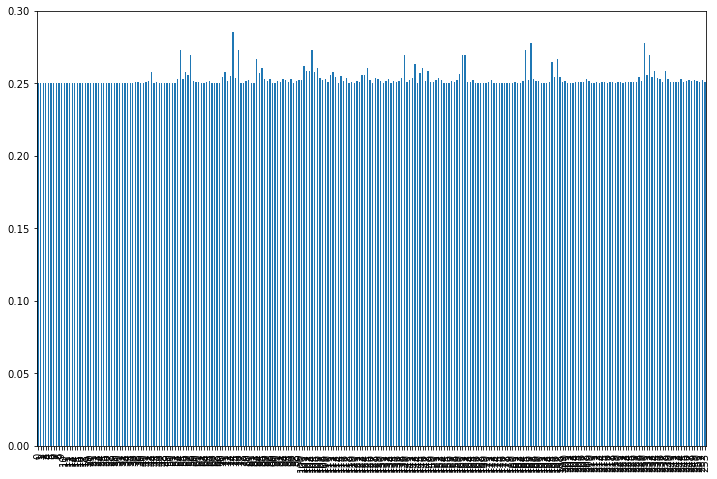

In [4]:
# That assignment should pass the autograder. A more pythonic way to do this, and certainly
# the goal of the sklearn team, is to use pipelines, and reuse transformer objects to do the
# data cleaning. In sklearn pipelines are made up of a sequence of Transformers with the last
# item in the pipeline being an Estimator. You can have Estimators throughout the pipeline
# too, creating new features through modeling. For instance, you could use PCA to reduce the
# dimensionality of features and then learn on principal components instead.

plt.figure(figsize=(12, 8))

# We can write a similar model to the above using pipelines and transformers. A good example
# would be to first create a transformer for the columns of sex and age, and get rid of
# everything else while one hot encoding sex
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class CustomTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        # Just select the features we want
        
        #Clean Sex Column... Add male column
        # X = X[X['sex'].str.contains('NOT SPECIFIED|Unspecified')==False]

        conditions = [
            (X['sex'] == 'F'),
            (X['sex'] == 'M'),
            (X['sex'] == 'Female'),
            (X['sex'] == 'Male'),
            (X['sex'] == 'NOT SPECIFIED'),
            (X['sex'] == 'Unspecified')
        ]

        choices = [0,1,0,1,np.nan,np.nan]


        X['male'] = np.select(conditions, choices)
        
        #Clean Age Column...Add age_adj column
        
        # X['age_adj'] = X.loc[(X['age'] < 80) & (X['age'] > 5), 'age']
        
        X['age_adj'] = X['age'].apply(lambda x: x if x <= 79 else 79)
        
        #Clean Registered Distance Unit Column...Add dist_adj column
        
        X['dist_adj'] = np.where(X['category.registered.distance.unit'] == 'km', (X['category.registered.distance.quantity'] * .62137), X['category.registered.distance.quantity'])
        
        #Did they travel for the race?...Add traveled column
        
        X['home_state'] = [x[-2:] for x in X['hometown']]
        
        conditions = [
            (X['home_state'] == X['location.state']),
            (X['home_state'] != X['location.state'])
        ]

        choices = [0,1]
        
        X['traveled'] = np.select(conditions, choices)
        
        #Create Dummy Variable for Event Year...Add event_year_XXXX columns
        
        X['event_year'] = [i[:4] for i in X['event.date.start']]
        
        X['event_mo'] = [i[6:8] for i in X['event.date.start']]

        # X = pd.get_dummies(X, columns = ['event_year'])
        
        # event_year_cols = [col for col in X.columns if 'event_year_' in col]
        
        # event_year_cols =[]
        
        selected_cols = ['age_adj','male','bib','dist_adj','traveled','clean_categories.name','event.race.id','event_year','counts.participants.registered','event_mo','location.state']

        # selected_cols.extend(event_year_cols)

        Xprime=X[selected_cols]
        # Ensure that they have numbers in them of the regression will fail
        Xprime=Xprime.fillna(Xprime.median())
        
        print(Xprime.columns)
        
        return Xprime

# cleaner = ColumnTransformer(
#     transformers=[
#         ("sex", OneHotEncoder(categories=[['Male','Female']], handle_unknown='ignore'), ['sex']),
#         ('age', 'passthrough', ['age']),
#     ], remainder='drop')

# Then we create a three stage pipeline, where the first step applies the column transformer,
# the next step fills our missing values, and the third step is a regression model. But remember,
# this isn't a simple regression, we need an ordinal classification. To do this we can wrap
# the linear regressor in another class which will transform the regression output. This class
# is called the TransformedTargetRegressor, and we can tell it what function we want to apply
# to the final output before returning the predictions.

def evaluation_function(x):
    '''Must return a ndarray of the rankings in order, the autograder will then create
    a dataframe out of this with x.index as the index. Props to Rachell Calhoun!'''
    return pd.Series(x.squeeze()).rank().values

# We can wrap a linear regressor by setting the inverse_func to evaluation_function
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
reg=TransformedTargetRegressor(regressor=LinearRegression(), inverse_func=evaluation_function)

# Now we can build our three part pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
pipe = Pipeline(
    steps=[
        ("custom", CustomTransformer()),
        ("reduce_columns", 
         ColumnTransformer(transformers=[
            ("clean_categories.name", OneHotEncoder(handle_unknown='ignore'), ['clean_categories.name']),
            ("event_year", OneHotEncoder(handle_unknown='ignore'), ['event_year']),
            ("event_mo", OneHotEncoder(handle_unknown='ignore'), ['event_mo']),
            ("location.state", OneHotEncoder(handle_unknown='ignore'), ['location.state'])
            ], remainder='drop'),
        ),
        ("fix_nans", SimpleImputer(missing_values=np.nan, strategy='median')),
        ("regressor", reg)
    ])

# We can display the pipeline to see what it looks like and get a sense of data flow
from sklearn import set_config
set_config(display="diagram")
display(pipe)

# We can then fit the data in the pipeline
fitted_pipe=pipe.fit(train,y)

# And we can save it to an output file
cloudpickle.dump(fitted_pipe, open('pipeline.cloudpickle','wb'))
# Then telling the autograder function to fire
autograde(holdout)

In [ ]:
clfs={}

# Let's create a couple of different of descision trees
from sklearn.tree import DecisionTreeClassifier

# - one which has only a depth of 3
clfs["dt0"]=DecisionTreeClassifier(max_depth=3, random_state=1337)
# - one which requires there to be at least 7 samples at each leaf
clfs["dt1"]=DecisionTreeClassifier(min_samples_leaf=7, random_state=1337)
# - and one which balances the classes since we have unbalanced data
clfs["dt2"]=DecisionTreeClassifier(class_weight="balanced", random_state=1337)

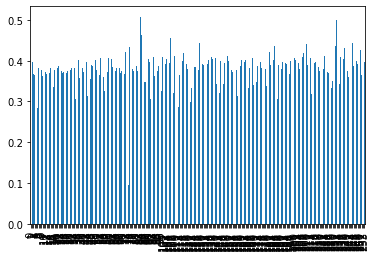

In [28]:
results = autograde(holdout)

In [42]:
# results.groupby(['clean_categories.name'].mean())

results.reset_index()

results.groupby(by = ['clean_categories.name']).mean()

# results.dtypes

,score
clean_categories.name,
1 mile,0.394038
1 mile fun run,0.095238
1 mile fun run/walk,0.426043
1 mile run,0.386594
1 mile walk,0.343874
10 mile run,0.381818
10 mile walk,0.335055
10k,0.396021
10k run,0.397690
